In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import pickle
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
class Config:
    def __init__(self):
        # Model
        self.hidden_size = 128
        self.dropout = 0.3
        
        # Training
        self.batch_size = 32
        self.epochs = 15
        self.learning_rate = 0.001
        
        # Data
        self.max_length = 80
        self.threshold = 0.5
        
        # Device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class MalwareDataset(Dataset):
    def __init__(self, sequences, numeric_features, labels, vocab, max_length):
        self.sequences = sequences
        self.numeric_features = numeric_features
        self.labels = labels
        self.max_length = max_length
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        if isinstance(seq, str) and seq:
            tokens = seq.split(';')
            indices = [self.vocab.get(token, 1) for token in tokens]
        else:
            indices = []
        
        # Pad or truncate
        if len(indices) > self.max_length:
            indices = indices[:self.max_length]
        else:
            indices += [0] * (self.max_length - len(indices))
        
        return {
            'sequence': torch.tensor(indices, dtype=torch.long),
            'numeric': torch.tensor(self.numeric_features[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [4]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, config):
        super(BiLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, 64, padding_idx=0)
        self.lstm = nn.LSTM(64, config.hidden_size, batch_first=True, bidirectional=True)
        
        # Simple classifier
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size * 2 + 4, 64),  # +4 for numeric features
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(64, 2)
        )
        
    def forward(self, sequence, numeric):
        embedded = self.embedding(sequence)
        lstm_out, (hidden, _) = self.lstm(embedded)
        
        # Use last hidden state
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        
        # Combine features
        combined = torch.cat((hidden, numeric), dim=1)
        output = self.classifier(combined)
        
        return output


In [5]:
class MalwareDetector:
    def __init__(self, config=None):
        self.config = config or Config()
        self.vocab = {}
        self.scaler = StandardScaler()
        self.model = None
        
    def build_vocab(self, sequences):
        """Build simple vocabulary"""
        from collections import Counter
        tokens = Counter()
        for seq in sequences:
            if isinstance(seq, str) and seq:
                tokens.update(seq.split(';'))
        
        self.vocab = {'<PAD>': 0, '<UNK>': 1}
        for token, count in tokens.most_common(5000):  # Top 5000 tokens
            if count >= 2:
                self.vocab[token] = len(self.vocab)
        
        print(f"Vocabulary size: {len(self.vocab)}")
        return self.vocab
    
    def prepare_data(self, malware_csv, benign_csv):
        """Simple data preparation"""
        # Load data
        df_mal = pd.read_csv(malware_csv)
        df_ben = pd.read_csv(benign_csv)
        df = pd.concat([df_mal, df_ben], ignore_index=True)
        
        print(f"Loading: {len(df_mal)} malware + {len(df_ben)} benign samples")
        
        # Combine sequence features
        sequence_cols = ['exec_processes_seq', 'exec_paths_seq', 'dns_queries_seq', 
                        'udp_ports_seq', 'hosts_seq', 'sig_names_seq']
        
        sequences = []
        for _, row in df.iterrows():
            parts = [str(row[col]) for col in sequence_cols if pd.notna(row[col]) and row[col]]
            sequences.append(';'.join(parts))
        
        # Numeric features
        numeric_cols = ['num_execs', 'num_unique_execs', 'num_dns_queries', 'num_udp_packets']
        numeric_features = df[numeric_cols].fillna(0).values
        labels = df['label'].values
        
        # Build vocab
        self.build_vocab(sequences)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            list(zip(sequences, numeric_features)), labels, 
            test_size=0.2, random_state=42, stratify=labels
        )
        
        # Process features
        train_seq, train_num = zip(*X_train)
        test_seq, test_num = zip(*X_test)
        
        train_num = self.scaler.fit_transform(np.array(train_num))
        test_num = self.scaler.transform(np.array(test_num))
        
        # Create datasets
        train_dataset = MalwareDataset(train_seq, train_num, y_train, self.vocab, self.config.max_length)
        test_dataset = MalwareDataset(test_seq, test_num, y_test, self.vocab, self.config.max_length)
        
        train_loader = DataLoader(train_dataset, batch_size=self.config.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.config.batch_size, shuffle=False)
        
        return train_loader, test_loader
    
    def train(self, train_loader, test_loader):
        self.model = BiLSTM(len(self.vocab), self.config).to(self.config.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.config.learning_rate)
        
        print(f"Training for {self.config.epochs} epochs on {self.config.device}...")
        
        best_acc = 0
        for epoch in range(self.config.epochs):
            # Training
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            for batch in train_loader:
                seq = batch['sequence'].to(self.config.device)
                num = batch['numeric'].to(self.config.device)
                labels = batch['label'].to(self.config.device)
                
                optimizer.zero_grad()
                outputs = self.model(seq, num)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()
            
            # Validation
            val_acc = self.quick_evaluate(test_loader)
            
            train_acc = 100. * train_correct / train_total
            print(f"Epoch {epoch+1:2d}/{self.config.epochs} | "
                  f"Train: {train_acc:5.1f}% | Val: {val_acc:5.1f}%")
            
            # Save best model
            if val_acc > best_acc:
                best_acc = val_acc
                self.save_model()
        
        print(f"✅ Training done! Best accuracy: {best_acc:.1f}%")
    
    def quick_evaluate(self, test_loader):
        """Quick evaluation for training"""
        self.model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                seq = batch['sequence'].to(self.config.device)
                num = batch['numeric'].to(self.config.device)
                labels = batch['label'].to(self.config.device)
                
                outputs = self.model(seq, num)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        return 100. * correct / total
    
    def evaluate_with_confidence(self, test_loader):
        """Detailed evaluation with confidence scores"""
        self.model.eval()
        all_probs = []
        all_labels = []
        all_confidences = []
        
        with torch.no_grad():
            for batch in test_loader:
                seq = batch['sequence'].to(self.config.device)
                num = batch['numeric'].to(self.config.device)
                labels = batch['label'].to(self.config.device)
                
                outputs = self.model(seq, num)
                probs = torch.softmax(outputs, dim=1)
                
                # Get malware probabilities and confidence scores
                malware_probs = probs[:, 1].cpu().numpy()
                confidences = torch.max(probs, dim=1)[0].cpu().numpy()  # Max probability as confidence
                
                all_probs.extend(malware_probs)
                all_labels.extend(labels.cpu().numpy())
                all_confidences.extend(confidences)
        
        all_probs = np.array(all_probs)
        all_labels = np.array(all_labels)
        all_confidences = np.array(all_confidences)
        
        # Find optimal threshold
        best_threshold = self.find_best_threshold(all_labels, all_probs)
        self.config.threshold = best_threshold
        
        # Get predictions with optimal threshold
        predictions = (all_probs >= self.config.threshold).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, predictions)
        auc_score = roc_auc_score(all_labels, all_probs)
        
        # Confidence analysis
        high_conf_mask = all_confidences >= 0.8
        med_conf_mask = (all_confidences >= 0.6) & (all_confidences < 0.8)
        low_conf_mask = all_confidences < 0.6
        
        high_conf_acc = accuracy_score(all_labels[high_conf_mask], predictions[high_conf_mask]) if high_conf_mask.sum() > 0 else 0
        med_conf_acc = accuracy_score(all_labels[med_conf_mask], predictions[med_conf_mask]) if med_conf_mask.sum() > 0 else 0
        low_conf_acc = accuracy_score(all_labels[low_conf_mask], predictions[low_conf_mask]) if low_conf_mask.sum() > 0 else 0
        
        print("=" * 50)
        
        # Show sample predictions with confidence during evaluation
        print(f"\n🔍 Sample Predictions with Confidence:")
        print(f"{'Sample':<8} {'True':<8} {'Pred':<8} {'Confidence':<12} {'Malware Prob':<12}")
        print("-" * 55)
        
        # Show first 10 samples
        for i in range(min(10, len(all_labels))):
            true_label = 'Malware' if all_labels[i] == 1 else 'Benign'
            pred_label = 'Malware' if predictions[i] == 1 else 'Benign'
            confidence = all_confidences[i]
            malware_prob = all_probs[i]
            
            print(f"{i+1:<8} {true_label:<8} {pred_label:<8} {confidence:<12.3f} {malware_prob:<12.3f}")
        
        print("=" * 50)
        print("📊 EVALUATION RESULTS")
        print("=" * 50)
        print(f"🎯 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
        print(f"📈 ROC AUC Score:    {auc_score:.4f}")
        print(f"🎚️  Optimal Threshold: {best_threshold:.3f}")
        
        print(f"\n🔍 Confidence Analysis:")
        print(f"High Confidence (≥0.8): {high_conf_mask.sum():4d} samples, Accuracy: {high_conf_acc:.3f}")
        print(f"Med  Confidence (0.6-0.8): {med_conf_mask.sum():4d} samples, Accuracy: {med_conf_acc:.3f}")
        print(f"Low  Confidence (<0.6): {low_conf_mask.sum():4d} samples, Accuracy: {low_conf_acc:.3f}")
        
        print(f"\n📋 Classification Report:")
        report = classification_report(all_labels, predictions, target_names=['Benign', 'Malware'], digits=3, output_dict=True)
        
        # Print formatted classification report
        print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
        print("-" * 60)
        
        for class_name in ['Benign', 'Malware']:
            metrics = report[class_name]  # Use exact class name, not lowercase
            print(f"{class_name:<10} {metrics['precision']:<10.3f} {metrics['recall']:<10.3f} {metrics['f1-score']:<10.3f} {metrics['support']:<10.0f}")
        
        # Overall metrics
        print("-" * 60)
        print(f"{'Accuracy':<10} {'':<10} {'':<10} {report['accuracy']:<10.3f} {report['macro avg']['support']:<10.0f}")
        print(f"{'Macro Avg':<10} {report['macro avg']['precision']:<10.3f} {report['macro avg']['recall']:<10.3f} {report['macro avg']['f1-score']:<10.3f} {report['macro avg']['support']:<10.0f}")
        print(f"{'Weighted Avg':<10} {report['weighted avg']['precision']:<10.3f} {report['weighted avg']['recall']:<10.3f} {report['weighted avg']['f1-score']:<10.3f} {report['weighted avg']['support']:<10.0f}")
        
        print("=" * 50)
        
        return {
            'accuracy': accuracy,
            'auc': auc_score,
            'threshold': best_threshold,
            'high_conf_acc': high_conf_acc,
            'med_conf_acc': med_conf_acc,
            'low_conf_acc': low_conf_acc,
            'classification_report': report,
            'confidence_stats': {
                'high_conf_samples': high_conf_mask.sum(),
                'med_conf_samples': med_conf_mask.sum(),
                'low_conf_samples': low_conf_mask.sum()
            }
        }
    
    def find_best_threshold(self, labels, probs):
        """Find optimal threshold based on F1 score"""
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            preds = (probs >= threshold).astype(int)
            
            # Calculate F1 for malware class
            tp = np.sum((preds == 1) & (labels == 1))
            fp = np.sum((preds == 1) & (labels == 0))
            fn = np.sum((preds == 0) & (labels == 1))
            
            if tp + fp > 0 and tp + fn > 0:
                precision = tp / (tp + fp)
                recall = tp / (tp + fn)
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
        
        return best_threshold
    
    def predict_sample(self, sequence, numeric_features, simple_output=False):
        """Predict single sample with options for output format"""
        self.model.eval()
        
        # Process sequence
        if isinstance(sequence, str) and sequence:
            tokens = sequence.split(';')
            indices = [self.vocab.get(token, 1) for token in tokens]
        else:
            indices = []
        
        # Pad/truncate
        if len(indices) > self.config.max_length:
            indices = indices[:self.config.max_length]
        else:
            indices += [0] * (self.config.max_length - len(indices))
        
        # Convert to tensors
        seq_tensor = torch.tensor([indices], dtype=torch.long).to(self.config.device)
        num_tensor = torch.tensor([numeric_features], dtype=torch.float32).to(self.config.device)
        
        with torch.no_grad():
            outputs = self.model(seq_tensor, num_tensor)
            probs = torch.softmax(outputs, dim=1)
            
            malware_prob = probs[0, 1].item()
            confidence = torch.max(probs, dim=1)[0].item()
            prediction = 1 if malware_prob >= self.config.threshold else 0
        
        if simple_output:
            # Simple output: hanya label dan malware probability
            return {
                'label': 'Malware' if prediction == 1 else 'Benign',
                'malware_probability': malware_prob
            }
        else:
            # Full output: semua informasi
            return {
                'prediction': prediction,
                'label': 'Malware' if prediction == 1 else 'Benign',
                'malware_probability': malware_prob,
                'confidence': confidence
            }
    
    def save_model(self):
        """Save model and artifacts"""
        os.makedirs('model', exist_ok=True)
        
        torch.save(self.model.state_dict(), 'model/simple_bilstm.pth')
        
        with open('model/vocab.pkl', 'wb') as f:
            pickle.dump(self.vocab, f)
        joblib.dump(self.scaler, 'model/scaler.pkl')
        
        config_dict = {
            'hidden_size': self.config.hidden_size,
            'dropout': self.config.dropout,
            'max_length': self.config.max_length,
            'threshold': self.config.threshold
        }
        with open('model/config.pkl', 'wb') as f:
            pickle.dump(config_dict, f)
    
    def plot_simple_results(self, test_loader):
        """Simple result visualization with ROC curve and confusion matrix"""
        # Get data for plotting
        self.model.eval()
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                seq = batch['sequence'].to(self.config.device)
                num = batch['numeric'].to(self.config.device)
                labels = batch['label'].to(self.config.device)
                
                outputs = self.model(seq, num)
                probs = torch.softmax(outputs, dim=1)
                
                malware_probs = probs[:, 1].cpu().numpy()
                
                all_probs.extend(malware_probs)
                all_labels.extend(labels.cpu().numpy())
        
        # Get predictions for confusion matrix
        predictions = (np.array(all_probs) >= self.config.threshold).astype(int)
        
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        roc_auc = auc(fpr, tpr)
        
        ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
        ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('ROC Curve - Malware Detection')
        ax1.legend(loc="lower right")
        ax1.grid(True, alpha=0.3)
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, predictions)
        
        # Plot confusion matrix
        im = ax2.imshow(cm, interpolation='nearest', cmap='Blues')
        ax2.figure.colorbar(im, ax=ax2)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax2.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black",
                        fontsize=14, fontweight='bold')
        
        ax2.set_xlabel('Predicted Label')
        ax2.set_ylabel('True Label')
        ax2.set_title('Confusion Matrix')
        ax2.set_xticks([0, 1])
        ax2.set_yticks([0, 1])
        ax2.set_xticklabels(['Benign', 'Malware'])
        ax2.set_yticklabels(['Benign', 'Malware'])
        
        plt.tight_layout()
        plt.savefig('results_plots.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"📈 ROC AUC Score: {roc_auc:.4f}")
        print(f"🔍 Confusion Matrix:")
        print(f"   True Negatives (Benign→Benign):   {cm[0,0]:4d}")
        print(f"   False Positives (Benign→Malware): {cm[0,1]:4d}")
        print(f"   False Negatives (Malware→Benign): {cm[1,0]:4d}")
        print(f"   True Positives (Malware→Malware): {cm[1,1]:4d}")
    
    def run(self, malware_csv="fitur_malware.csv", benign_csv="fitur_benign.csv"):
        """Complete simplified pipeline"""
        print("🚀 Simple BiLSTM Malware Detector")
        
        # Prepare data
        train_loader, test_loader = self.prepare_data(malware_csv, benign_csv)
        
        # Train model
        self.train(train_loader, test_loader)
        
        # Load best model
        self.model.load_state_dict(torch.load('model/simple_bilstm.pth', map_location=self.config.device))
        
        # Evaluate with confidence
        results = self.evaluate_with_confidence(test_loader)
        
        # Plot results
        self.plot_simple_results(test_loader)
        
        return results

🚀 Simple BiLSTM Malware Detector
Loading: 1258 malware + 1218 benign samples
Vocabulary size: 2368
Training for 20 epochs on cpu...
Epoch  1/20 | Train:  79.4% | Val:  85.5%
Epoch  2/20 | Train:  85.2% | Val:  86.5%
Epoch  3/20 | Train:  85.7% | Val:  87.1%
Epoch  4/20 | Train:  86.5% | Val:  87.1%
Epoch  5/20 | Train:  86.6% | Val:  86.9%
Epoch  6/20 | Train:  86.6% | Val:  87.3%
Epoch  7/20 | Train:  86.9% | Val:  87.1%
Epoch  8/20 | Train:  86.8% | Val:  87.1%
Epoch  9/20 | Train:  87.3% | Val:  86.9%
Epoch 10/20 | Train:  87.8% | Val:  87.1%
Epoch 11/20 | Train:  87.9% | Val:  87.3%
Epoch 12/20 | Train:  87.8% | Val:  86.3%
Epoch 13/20 | Train:  87.4% | Val:  87.1%
Epoch 14/20 | Train:  87.2% | Val:  87.3%
Epoch 15/20 | Train:  88.1% | Val:  86.7%
Epoch 16/20 | Train:  87.9% | Val:  86.7%
Epoch 17/20 | Train:  88.5% | Val:  86.7%
Epoch 18/20 | Train:  88.2% | Val:  87.3%
Epoch 19/20 | Train:  88.3% | Val:  86.9%
Epoch 20/20 | Train:  88.3% | Val:  86.1%
✅ Training done! Best accura

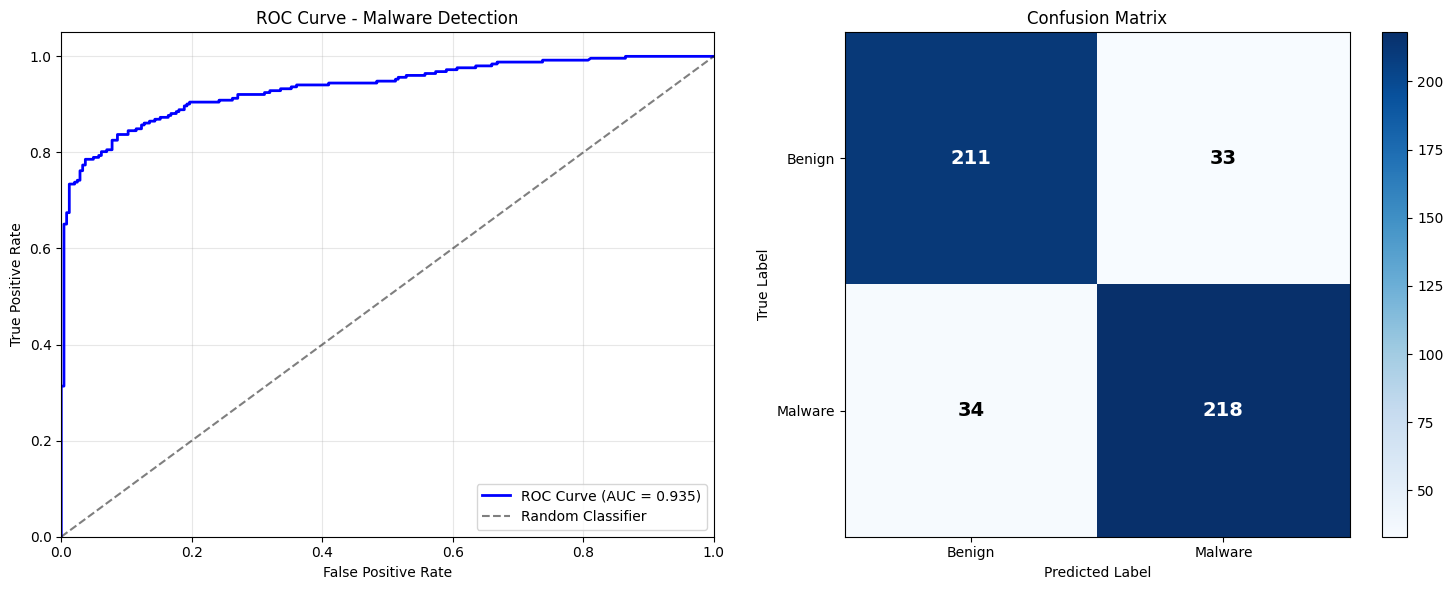

📈 ROC AUC Score: 0.9350
🔍 Confusion Matrix:
   True Negatives (Benign→Benign):    211
   False Positives (Benign→Malware):   33
   False Negatives (Malware→Benign):   34
   True Positives (Malware→Malware):  218

🎯 Summary:
   Accuracy: 0.865
   AUC Score: 0.935
   Threshold: 0.300
   Malware F1: 0.867
   Malware Precision: 0.869
   Malware Recall: 0.865

🔍 Example Prediction:
Full output: {'prediction': 1, 'label': 'Malware', 'malware_probability': 0.9953495860099792, 'confidence': 0.9953495860099792}
Simple output: {'label': 'Malware', 'malware_probability': 0.9953495860099792}


In [6]:
def simple_train(epochs=15, hidden_size=128, threshold=0.5):
    """Simplified training function"""
    config = Config()
    config.epochs = epochs
    config.hidden_size = hidden_size
    config.threshold = threshold
    
    detector = MalwareDetector(config)
    results = detector.run()
    
    print(f"\n🎯 Summary:")
    print(f"   Accuracy: {results['accuracy']:.3f}")
    print(f"   AUC Score: {results['auc']:.3f}")
    print(f"   Threshold: {results['threshold']:.3f}")
    print(f"   Malware F1: {results['classification_report']['Malware']['f1-score']:.3f}")
    print(f"   Malware Precision: {results['classification_report']['Malware']['precision']:.3f}")
    print(f"   Malware Recall: {results['classification_report']['Malware']['recall']:.3f}")
    
    return detector, results

# Example usage
if __name__ == "__main__":
    detector, results = simple_train(epochs=20)
    
    # Example prediction with confidence
    print("\n🔍 Example Prediction:")
    sample_seq = "calc.exe;notepad.exe"
    sample_numeric = [2, 1, 5, 3]  # num_execs, num_unique_execs, num_dns_queries, num_udp_packets
    
    # Full output
    result_full = detector.predict_sample(sample_seq, sample_numeric, simple_output=False)
    print("Full output:", result_full)
    
    # Simple output (only label + malware probability)
    result_simple = detector.predict_sample(sample_seq, sample_numeric, simple_output=True)
    print("Simple output:", result_simple)